In [1]:
import sys
# This makes the gdc19 package avaialble
sys.path.append('../')

In [2]:
import gdc19
import PVGeo
import vtki
import vtk
import omfvtk
import lasio

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Links:

- https://utahforge.com/studentcomp/?utm_source=Hubspot%20intro%20email010719&utm_source=hs_automation&utm_campaign=INL%20GDC%2019&utm_medium=email&utm_content=68794775&_hsenc=p2ANqtz--LMrr-vFzFD78-VnPLfeSy2tBImWRaDKacFvVBB19ebQ_Ry9Sm0hUEzE1GbNz0iRLniFjYKGNcFFJ_8V9_kxtKabsoMQ&_hsmi=68794775


Notes:

- LIVE webinar on January 25.


Data:

- UTM, zone 12N, NAD 83, NAVD 88.


-----

# File IO

This notebook runs through all of the data files given in the project and reads them into useable, spatially-referenced data object.

In [4]:
# Be sure to set your working directory!!!
# this is the path to the Google Drive folder
gdc19.set_data_directory('/Volumes/GoogleDrive/My Drive/utah-forge')

'/Volumes/GoogleDrive/My Drive/utah-forge'

-----
## Well Data

Incomplete.

We'll use some of [`lasio`](https://lasio.readthedocs.io/en/latest/) for the file IO

In [5]:
las = lasio.read(gdc19.get_well_path(r'Acord 1-26_digitized_geophysical_well_log.las'))
las.curvesdict.keys()

dict_keys(['DEPT', 'BAD_RHOB', 'BITSIZE', 'CALI', 'DRHO', 'DT', 'GAMMA_RAY_SPLICE', 'GR_PROCESS', 'GR_SPLICE', 'LLD_SPLICE', 'LLM_SPLICE', 'LLS_SPLICE', 'NEUTRON_SPLICE', 'RHOB_PROCESSING', 'RHOB_SPLICE', 'SP_SLICE', 'TEMPERATURE_DEEP', 'TEMPERATURE_SHALLOW'])

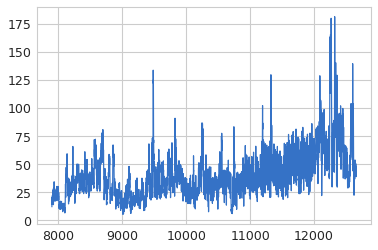

In [6]:
plt.plot(las.index, las["GAMMA_RAY_SPLICE"])

## Surfaces

Load in the 3D surface files

Tasks:

- [x] Load all surfaces
- [x] Mesh the regular topography and granitoid surfaces
- [ ] Mesh the irregular surfaces

In [7]:
surfaces = vtki.MultiBlock()

In [8]:
gdc19.list_filenames('surfaces')

['land_surface_vertices.csv',
 'top_granitoid_vertices.csv',
 'Negro_Mag_Fault_vertices.csv',
 '175C_vertices.csv',
 'Opal_Mound_Fault_vertices.csv',
 '225C_vertices.csv']

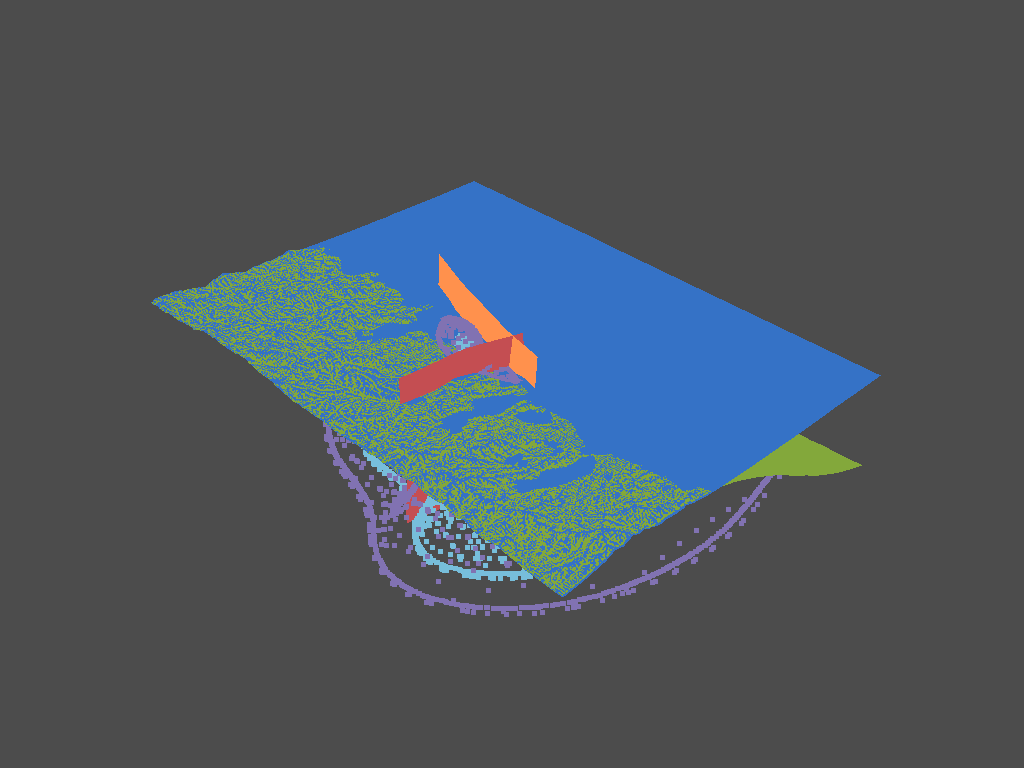

In [9]:
surfaces[0, 'land_surface'] = gdc19.read_surface_verts(gdc19.get_surfaces_path('land_surface_vertices.csv'),
                                                                               grid=True)
surfaces[1, 'top_granitoid'] = gdc19.read_surface_verts(gdc19.get_surfaces_path('top_granitoid_vertices.csv'),
                                                        grid=True)
surfaces[2, 'negro_mag_fault']  = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('Negro_Mag_Fault_vertices.csv')))
surfaces[3, '175c'] = gdc19.read_surface_verts(gdc19.get_surfaces_path('175C_vertices.csv'))
surfaces[4, 'opal_mound_fault'] = gdc19.delauney(gdc19.read_surface_verts(gdc19.get_surfaces_path('Opal_Mound_Fault_vertices.csv')))
surfaces[5, '225c'] = gdc19.read_surface_verts(gdc19.get_surfaces_path('225C_vertices.csv'))
surfaces.plot(notebook=True, show_edges=False, multi_colors=True)
                                                       
#

In [10]:
surf = surfaces['225c']
topo = surfaces['land_surface']
surf

vtkPolyData,Information
N Cells,6433
N Points,6433
X Bounds,"3.297e+05, 3.425e+05"
Y Bounds,"4.255e+06, 4.267e+06"
Z Bounds,"-2.606e+03, 1.925e+03"
N Scalars,0


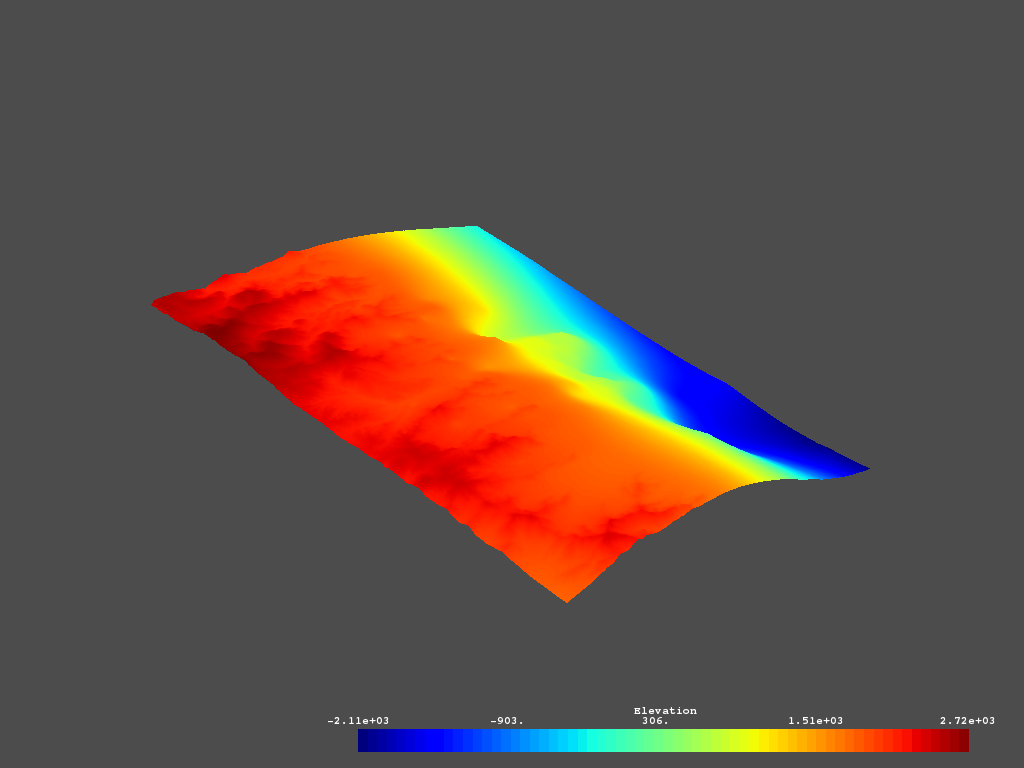

In [11]:
surfaces['top_granitoid'].plot(show_edges=False)#.save('top_granitoid.vtk')

## Temperature Data

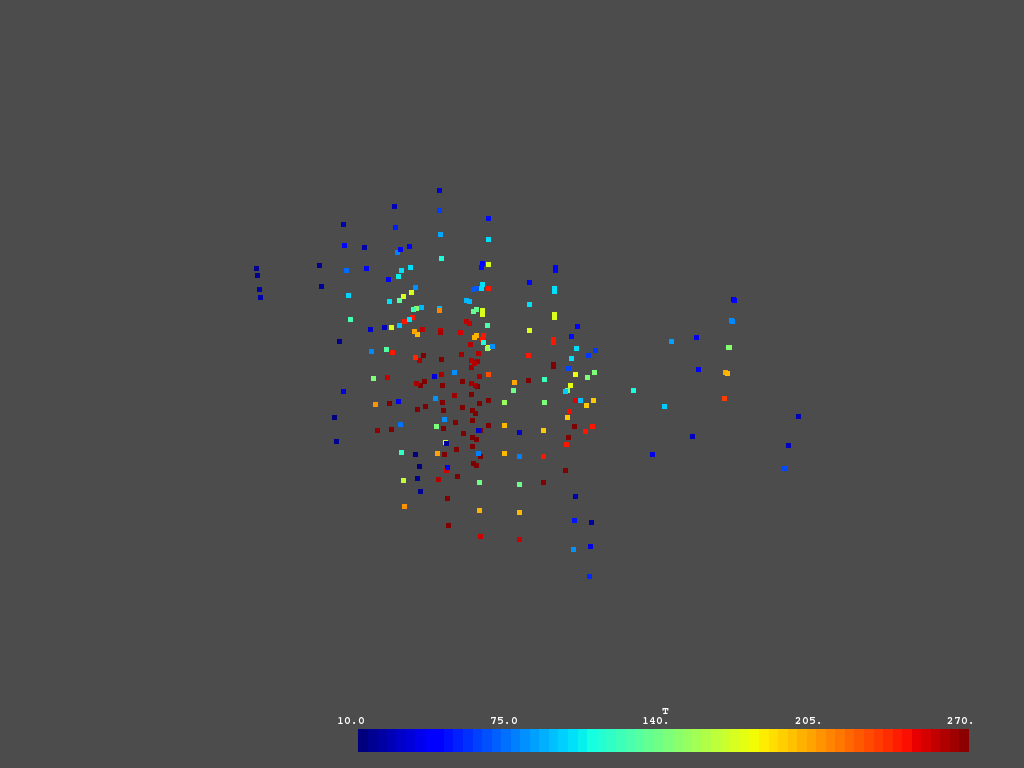

In [12]:
# Temperature data
temp = PVGeo.pointsToPolyData(
        pd.read_csv(
            gdc19.get_temperature_path('well_based_temperature.csv')
            )
        )
temp.plot(notebook=True)

## Injection Data

Not sure how to use these data yet...

In [13]:
injections = []
for f in gdc19.list_filenames('injection'):
    injections.append(pd.read_csv(gdc19.get_injection_path(f)))

In [14]:
injections[0].head()

,Time (hr),Pressure (psi),Pressure (MPa)
0,0.000000,11.839995,0.081634
1,0.001389,11.839508,0.081631
2,0.002778,11.848282,0.081691
3,0.004167,11.853885,0.081730
4,0.005556,11.858296,0.081760


In [15]:
injections[1].head()

,Time (hr),Flow (barrel/min),Flow (Liter/min)
0,13.152500,0.1,15.898729
1,13.152778,0.2,31.797459
2,13.153056,0.2,31.797459
3,13.153333,0.2,31.797459
4,13.153611,0.3,47.696188


## Drilling

Not sure yet

## GIS Data


```
conda install gdal
```

Tasks:

- [x] Load and associate textures to the topography
- [ ] Load shapefiles


In [16]:
gdc19.load_attach_texture(topo, 
                          gdc19.get_gis_path('Geologic_map_on_air_photo.tif'), 
                          'geo-air')
gdc19.load_attach_texture(topo, 
                          gdc19.get_gis_path('Geologic_map_no_quaternary.tif'), 
                          'geo-no-q')
gdc19.load_attach_texture(topo, 
                          gdc19.get_gis_path('topographic_map.tif'), 
                          'topo-map')

In [17]:
topo

(StructuredGrid)0xb2e4f96a8

# Integrated Scene

In [18]:
p = vtki.BackgroundPlotter()
p.add_bounds_axes()

(vtkRenderingAnnotationPython.vtkCubeAxesActor)0xb3ec51948

In [20]:
p.add_mesh(temp, cmap='coolwarm', name='temp', psize=10)
p.add_mesh(surfaces['negro_mag_fault'], 
           name='negro_mag_fault', show_edges=False, color='blue')
p.add_mesh(surfaces['opal_mound_fault'], 
           name='opal_mound_fault', show_edges=False, color='orange')

(vtkRenderingOpenGL2Python.vtkOpenGLActor)0xb3ec51f48

In [ ]:
# We can update this cell to change the texture
p.add_mesh(topo, 
           texture='geo-no-q', 
           show_edges=False, 
           name='topo', 
           reset_camera=False)

In [22]:
p.reset_camera()